# Projeto de Deep Learning

## Bibliotecas Utilizadas

In [1]:
import pandas as pd
from numpy import array
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, accuracy_score, mean_absolute_error
from pylab import rcParams
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow import keras
import scipy.stats as stats
from scipy.stats import iqr
rcParams['figure.figsize'] = 9,5

## Funções Necessárias

In [4]:
class DefineEstacoes():
    #Separa o conjunto de dados de acordo com as estações
    
    def __init__(self,dados):
        # Inicializa o atributo às estações
        self.dados = dados

    def outono(self):
        return np.concatenate([self.dados[46512:52561],self.dados[0:7344]])

    def inverno(self):
        return self.dados[7344:20736]

    def primavera(self):
        return self.dados[20736:33696]

    def verao(self):
        return self.dados[33696:46512]
    
    def une(self):
        return np.concatenate([self.outono(),self.inverno(),self.primavera(),self.verao()])

        

In [5]:
class TrataHora():
    #Converte os dados de minutos para horas e separa de acordo com os períodos de maior irradiação
    
    def __init__(self,dados):
        # Inicializa o atributo para o tratamento
        self.dados = dados
        
    def separa_horas(self):
        # Separa os 6 registros em minutos de cada hora num array (ex.: 00:10 até 01:00...)
        return [self.dados[i*6:(i+1)*6] for i in range(int(len(self.dados)/6))]

    def horas_uteis(self):
        # Seleciona o intervalo horário de 8-16 dentro de todos os dias do conjunto
        return np.concatenate([self.separa_horas()[(j*24):24+(j*24)] for j in range(int(len(self.separa_horas())/24))])
    
    def media(self):
        # Realiza a média horária dos dados
        var = self.horas_uteis()
        data = []
        for k in range(len(var)):
            data.append(np.mean(var[k]))
        return data

In [6]:
class ProcessamentoRede():
    # Prepara os dados de forma adequada para se tornarem a entrada das redes
    
    def __init__(self,dados):
        # Inicializa o atributo para o tratamento
        self.dados = dados
        
    def create_dataset(self, look_back=1):
        # Cria os datasets à previsão
        dataX, dataY = [], []
        for i in range(len(self.dados)-look_back-1):
            a = self.dados[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(self.dados[i + look_back, 0])
        return np.array(dataX), np.array(dataY)

    def formato(self):
        # formata o tipo dos dados para float32
        return self.dados.astype('float32')
    
    def size_treino(self,tamanho=0.8):
        # Define o tamanho do conjunto de treino
        return int(len(self.dados) * tamanho)
        
    def size_teste(self):
        # Define o tamanho do conjunto de teste
        return int(len(self.dados)- self.size_treino())
        
    def treino(self):
        # Faz a separação dos dados de treino
        return self.dados[0:self.size_treino()]
           
    def teste(self):
        # Faz a separação dos dados de teste
        return self.dados[self.size_treino():len(self.dados)]
    

In [7]:
class Metricas():

    def __init__(self,real,previsto):
        self.real = real
        self.previsto = previsto

    def mse(self):
        #Mean squared error
        mse = mean_squared_error(np.reshape(self.previsto,(-1,1)), np.reshape(self.real,(-1,1)))
        return round(mse,4)        

    def rmse(self):
        #Root mean square error
        rmse = mean_squared_error(np.reshape(self.previsto,(-1,1)), np.reshape(self.real,(-1,1)),squared=False)
        return np.round_(rmse,4)

    def mae(self):
        #Mean absolute error
        mae = mean_absolute_error(np.reshape(self.previsto,(-1,1)), np.reshape(self.real,(-1,1)))
        return np.round_(mae,4)

    def vaf(self):
        #Variance accounted
        vaf = explained_variance_score(np.reshape(self.previsto,(-1,1)), np.reshape(self.real,(-1,1)))
        return np.round_(vaf,4)

    def r2(self):
        # R²
        r2 = r2_score(np.reshape(self.previsto,(-1,1)), np.reshape(self.real,(-1,1)))
        return np.round_(r2,4)

    def viz(self):
        return print(f"{self.mse()}\n{self.rmse()}\n{self.mae()}\n{self.vaf()}\n{self.r2()}")

## Leitura dos Datasets

In [ ]:
dataset = pd.read_csv("banco_irece_completo.csv", index_col=0)
dataset = dataset['RadGlobalCMP11 (W/m2)_mean'][:52560].values

In [ ]:
dataset = DefineEstacoes(dataset).une()

In [ ]:
dataset = TrataHora(dataset).media()

## Processamento de dados
Verificando se existem outliers no conjunto

In [ ]:
# Separando todas as horas do dia
horas = [dataset[i::24] for i in range(0,24)]

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(horas)

ax.set_xticklabels([str(i) + 'h' for i in range(0,24)])
plt.show()

In [ ]:
# Identificando quais valores são prováveis outliers
for i in range(24):
    if (pd.DataFrame(horas).T[i].quantile(0.25) - 1.5*(iqr(horas[i]))) >=0:
        print(pd.DataFrame(horas).T[i].quantile(0.25) - 1.5*(iqr(horas[i])), pd.DataFrame(horas).T[i].quantile(0.75) + 1.5*(iqr(horas[i])))
    else:
        print(0, pd.DataFrame(horas).T[i].quantile(0.75) + 1.5*(iqr(horas[i])))


Como o período do início da manhã, fim de tarde e noturno possuem irradiações baixísimmas e/ou inexistentes devido à ausência do Sol, os períodos das 6 da manhã até 16 horas serão o principal foco para substituição dos outliers pela irradiação média da mesma hora. Nesses horários existem apenas outliers nos whiskers (bigodes) inferiores.

In [ ]:
# Calculando os limites para encontrar os Outliers Inferiores
for i in range(9,16): #Período com outliers 9h a 15h
    horas[i] = [np.median(horas[i]) if value <= (pd.DataFrame(horas).T[i].quantile(0.25) - 1.5*(iqr(horas[i]))) else value for value in horas[i]]

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(horas) #Período com outliers 9h a 15h

ax.set_xticklabels([str(i) + 'h' for i in range(0,24)])
plt.show()

In [ ]:
# Retornando os dados para a sequência horária de 0h até 23h
pd.DataFrame(horas).T.stack().values.reshape(8760, 1).astype('float32')

In [ ]:
pd.DataFrame(pd.DataFrame(horas).T.stack().values.reshape(8760, 1)).astype('float32').to_csv("df_sem_outliers.csv")

## Iniciando os dados para previsão

In [198]:
dt = pd.read_csv("df_sem_outliers.csv",index_col=0,header=0, names=['solar_irradiation(w/m²)'])
val = pd.read_csv("validacao.csv",index_col=0,header=0, names=['solar_irradiation(w/m²)'])
dt,val = dt.astype('float32'), val.astype('float32')

In [199]:
dt = dt.values
val = TrataHora(val).media()

In [200]:
scaler = MinMaxScaler()

In [201]:
dt = scaler.fit_transform(dt)
val = scaler.fit_transform(np.reshape(val,(-1,1)))
train_size = ProcessamentoRede(dt).size_treino(0.8)
test_size =  ProcessamentoRede(dt).size_teste()
train, test = ProcessamentoRede(dt).treino(), ProcessamentoRede(dt).teste()
trainX, trainY = ProcessamentoRede(train).create_dataset()
testX, testY = ProcessamentoRede(test).create_dataset()

# remodelando as entradas na forma (amostra, passos, features) -- tensores
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
val = np.reshape(val, (val.shape[0], 1, val.shape[1]))

#### MODELANDO A REDE AVANÇO PROFUNDO

In [224]:
# Rede DFF
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=1))
model.add(Dense(16))
model.add(Dense(16))
model.add(Dense(16))
model.add(Dense(8))
model.add(Dense(4))
model.add(Dense(2))
model.add(Dense(1, activation='relu'))

model.compile(loss='mse' , optimizer=keras.optimizers.Adam(learning_rate=0.005))
h = model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2,callbacks=[])

Epoch 1/20
7006/7006 - 13s - loss: 0.0175 - 13s/epoch - 2ms/step
Epoch 2/20
7006/7006 - 8s - loss: 0.0154 - 8s/epoch - 1ms/step
Epoch 3/20
7006/7006 - 8s - loss: 0.0149 - 8s/epoch - 1ms/step
Epoch 4/20
7006/7006 - 9s - loss: 0.0142 - 9s/epoch - 1ms/step
Epoch 5/20
7006/7006 - 8s - loss: 0.0140 - 8s/epoch - 1ms/step
Epoch 6/20
7006/7006 - 8s - loss: 0.0145 - 8s/epoch - 1ms/step
Epoch 7/20
7006/7006 - 8s - loss: 0.0137 - 8s/epoch - 1ms/step
Epoch 8/20
7006/7006 - 8s - loss: 0.0138 - 8s/epoch - 1ms/step
Epoch 9/20
7006/7006 - 8s - loss: 0.0135 - 8s/epoch - 1ms/step
Epoch 10/20
7006/7006 - 8s - loss: 0.0141 - 8s/epoch - 1ms/step
Epoch 11/20
7006/7006 - 8s - loss: 0.0137 - 8s/epoch - 1ms/step
Epoch 12/20
7006/7006 - 8s - loss: 0.0135 - 8s/epoch - 1ms/step
Epoch 13/20
7006/7006 - 8s - loss: 0.0137 - 8s/epoch - 1ms/step
Epoch 14/20
7006/7006 - 8s - loss: 0.0136 - 8s/epoch - 1ms/step
Epoch 15/20
7006/7006 - 8s - loss: 0.0136 - 8s/epoch - 1ms/step
Epoch 16/20
7006/7006 - 8s - loss: 0.0136 - 8s/

In [225]:
trainPredict = model.predict(trainX)
testPredict  = model.predict(testX)
valPredict   = model.predict(val)
                        
trainPredict = np.array([trainPredict[6+(j*24):17+(j*24)] for j in range(int(len(trainPredict)/24))]).flatten()
testPredict  = np.array([testPredict[6+(i*24):17+(i*24)] for i in range(int(len(testPredict)/24))]).flatten()
valPredict   = np.array([valPredict[6+(k*24):17+(k*24)] for k in range(int(len(valPredict)/24))]).flatten()

x = np.array([trainX[6+(q*24):17+(q*24)] for q in range(int(len(trainX)/24))]).flatten()
y = np.array([testX[6+(a*24):17+(a*24)] for a in range(int(len(testX)/24))]).flatten()
v = np.array([val[6+(z*24):17+(z*24)] for z in range(int(len(val)/24))]).flatten()

#### Avaliando o modelo DFF

In [226]:
Metricas(scaler.inverse_transform(np.reshape(x,(-1,1))),scaler.inverse_transform(np.reshape(trainPredict,(-1,1)))).viz()

868.5433959960938
29.471099853515625
26.654300689697266
0.9967
0.9817


In [227]:
Metricas(scaler.inverse_transform(np.reshape(y,(-1,1))),scaler.inverse_transform(np.reshape(testPredict,(-1,1)))).viz()

997.9475708007812
31.590299606323242
28.88409996032715
0.9967
0.9797


In [228]:
Metricas(scaler.inverse_transform(np.reshape(v,(-1,1))),scaler.inverse_transform(np.reshape(valPredict,(-1,1)))).viz()

924.4628295898438
30.405000686645508
27.26289939880371
0.9967
0.983


In [229]:
p1 = scaler.inverse_transform(np.reshape(x,(-1,1))).flatten()
p2 = scaler.inverse_transform(np.reshape(y,(-1,1))).flatten()
p3 = scaler.inverse_transform(np.reshape(v,(-1,1))).flatten()
r = pd.concat([pd.DataFrame(p),pd.DataFrame(p), pd.DataFrame(p)])

In [230]:
r2_D = scaler.inverse_transform(pd.concat([pd.DataFrame(trainPredict), pd.DataFrame(testPredict), pd.DataFrame(valPredict)]))

In [231]:
pd.DataFrame(r2_D,columns=['dff']).to_csv("previsao_dff.csv")

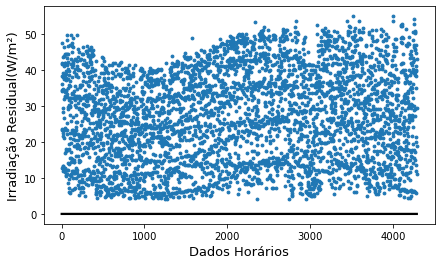

In [284]:
# Resíduos do modelo

rcParams['figure.figsize'] = 7,4
plt.xlabel("Dados Horários",fontsize=13)
plt.ylabel("Irradiação Residual(W/m²)",fontsize=13)
plt.scatter(np.arange(len(np.array(r) - np.array(r2_D))),np.array(r) - np.array(r2_D),s=8)


plt.plot(np.zeros(len(np.array(r) - np.array(r2_D))),color='black',linewidth=2.25)
plt.savefig("residuos-dff.png", dpi=500, bbox_inches='tight')

#### MODELANDO A REDE DE MEMÓRIA LONGA DE CURTO-PRAZO

In [90]:
# Rede LSTM
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.005))
h = model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2,callbacks=[])

Epoch 1/20
7006/7006 - 10s - loss: 0.0141 - 10s/epoch - 1ms/step
Epoch 2/20
7006/7006 - 9s - loss: 0.0130 - 9s/epoch - 1ms/step
Epoch 3/20
7006/7006 - 9s - loss: 0.0130 - 9s/epoch - 1ms/step
Epoch 4/20
7006/7006 - 10s - loss: 0.0128 - 10s/epoch - 1ms/step
Epoch 5/20
7006/7006 - 13s - loss: 0.0128 - 13s/epoch - 2ms/step
Epoch 6/20
7006/7006 - 10s - loss: 0.0127 - 10s/epoch - 1ms/step
Epoch 7/20
7006/7006 - 9s - loss: 0.0126 - 9s/epoch - 1ms/step
Epoch 8/20
7006/7006 - 10s - loss: 0.0125 - 10s/epoch - 1ms/step
Epoch 9/20
7006/7006 - 9s - loss: 0.0126 - 9s/epoch - 1ms/step
Epoch 10/20
7006/7006 - 9s - loss: 0.0124 - 9s/epoch - 1ms/step
Epoch 11/20
7006/7006 - 9s - loss: 0.0124 - 9s/epoch - 1ms/step
Epoch 12/20
7006/7006 - 15s - loss: 0.0124 - 15s/epoch - 2ms/step
Epoch 13/20
7006/7006 - 14s - loss: 0.0125 - 14s/epoch - 2ms/step
Epoch 14/20
7006/7006 - 10s - loss: 0.0124 - 10s/epoch - 1ms/step
Epoch 15/20
7006/7006 - 10s - loss: 0.0124 - 10s/epoch - 1ms/step
Epoch 16/20
7006/7006 - 9s - lo

In [92]:
trainPredict = model.predict(trainX)
testPredict  = model.predict(testX)
valPredict   = model.predict(val)
                        
trainPredict = np.array([trainPredict[6+(j*24):17+(j*24)] for j in range(int(len(trainPredict)/24))]).flatten()
testPredict  = np.array([testPredict[6+(i*24):17+(i*24)] for i in range(int(len(testPredict)/24))]).flatten()
valPredict   = np.array([valPredict[6+(k*24):17+(k*24)] for k in range(int(len(valPredict)/24))]).flatten()

x = np.array([trainX[6+(q*24):17+(q*24)] for q in range(int(len(trainX)/24))]).flatten()
y = np.array([testX[6+(a*24):17+(a*24)] for a in range(int(len(testX)/24))]).flatten()
v = np.array([val[6+(z*24):17+(z*24)] for z in range(int(len(val)/24))]).flatten()

#### Avaliando o modelo LSTM

In [94]:
Metricas(scaler.inverse_transform(np.reshape(x,(-1,1))),scaler.inverse_transform(np.reshape(trainPredict,(-1,1)))).viz()

685.2725219726562
26.17770004272461
24.02400016784668
0.9843
0.9839


In [95]:
Metricas(scaler.inverse_transform(np.reshape(y,(-1,1))),scaler.inverse_transform(np.reshape(testPredict,(-1,1)))).viz()

705.95361328125
26.569799423217773
24.53689956665039
0.9851
0.9841


In [96]:
Metricas(scaler.inverse_transform(np.reshape(v,(-1,1))),scaler.inverse_transform(np.reshape(valPredict,(-1,1)))).viz()

649.2177734375
25.479799270629883
23.535200119018555
0.9874
0.987


In [97]:
p1 = scaler.inverse_transform(np.reshape(x,(-1,1))).flatten()
p2 = scaler.inverse_transform(np.reshape(y,(-1,1))).flatten()
p3 = scaler.inverse_transform(np.reshape(v,(-1,1))).flatten()
r = pd.concat([pd.DataFrame(p1),pd.DataFrame(p2), pd.DataFrame(p3)])

In [98]:
r2_L = scaler.inverse_transform(pd.concat([pd.DataFrame(trainPredict), pd.DataFrame(testPredict), pd.DataFrame(valPredict)]))

In [99]:
pd.DataFrame(r2_L,columns=['lstm']).to_csv("previsao_lstm.csv")

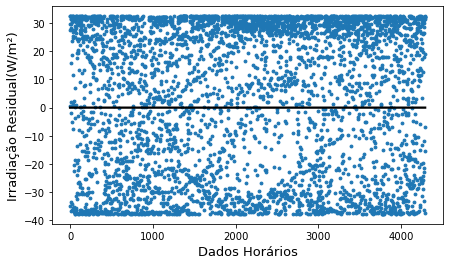

In [285]:
# Resíduos do modelo
rcParams['figure.figsize'] = 7,4
plt.scatter(np.arange(len(np.array(r) - np.array(r2_L))),np.array(r) - np.array(r2_L),s=8)
plt.ylabel("Irradiação Residual(W/m²)",fontsize=13)
plt.xlabel("Dados Horários",fontsize=13)

plt.plot(np.zeros(len(np.array(r) - np.array(r2_L))),color='black',linewidth=2.25)

plt.savefig("residuos-lstm.png", dpi=500, bbox_inches='tight')
plt.show()

#### Modelando a rede Convolucional

In [238]:
#Rede CNN
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(1, 1)))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(32))
model.add(Dense(32))
model.add(Dense(32))
model.add(Dense(2))
model.add(Dense(1))

model.compile(loss='mean_squared_error',  optimizer=keras.optimizers.Adam(learning_rate=0.005))
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2,callbacks=[])

Epoch 1/20
7006/7006 - 14s - loss: 0.0183 - 14s/epoch - 2ms/step
Epoch 2/20
7006/7006 - 11s - loss: 0.0147 - 11s/epoch - 2ms/step
Epoch 3/20
7006/7006 - 11s - loss: 0.0147 - 11s/epoch - 2ms/step
Epoch 4/20
7006/7006 - 15s - loss: 0.0149 - 15s/epoch - 2ms/step
Epoch 5/20
7006/7006 - 14s - loss: 0.0146 - 14s/epoch - 2ms/step
Epoch 6/20
7006/7006 - 12s - loss: 0.0140 - 12s/epoch - 2ms/step
Epoch 7/20
7006/7006 - 12s - loss: 0.0141 - 12s/epoch - 2ms/step
Epoch 8/20
7006/7006 - 8s - loss: 0.0141 - 8s/epoch - 1ms/step
Epoch 9/20
7006/7006 - 11s - loss: 0.0139 - 11s/epoch - 2ms/step
Epoch 10/20
7006/7006 - 9s - loss: 0.0139 - 9s/epoch - 1ms/step
Epoch 11/20
7006/7006 - 9s - loss: 0.0142 - 9s/epoch - 1ms/step
Epoch 12/20
7006/7006 - 8s - loss: 0.0140 - 8s/epoch - 1ms/step
Epoch 13/20
7006/7006 - 11s - loss: 0.0136 - 11s/epoch - 2ms/step
Epoch 14/20
7006/7006 - 10s - loss: 0.0138 - 10s/epoch - 1ms/step
Epoch 15/20
7006/7006 - 9s - loss: 0.0138 - 9s/epoch - 1ms/step
Epoch 16/20
7006/7006 - 10s -

In [239]:
trainPredict = model.predict(trainX)
testPredict  = model.predict(testX)
valPredict   = model.predict(val)
                        
trainPredict = np.array([trainPredict[6+(j*24):17+(j*24)] for j in range(int(len(trainPredict)/24))]).flatten()
testPredict  = np.array([testPredict[6+(i*24):17+(i*24)] for i in range(int(len(testPredict)/24))]).flatten()
valPredict   = np.array([valPredict[6+(k*24):17+(k*24)] for k in range(int(len(valPredict)/24))]).flatten()

x = np.array([trainX[6+(q*24):17+(q*24)] for q in range(int(len(trainX)/24))]).flatten()
y = np.array([testX[6+(a*24):17+(a*24)] for a in range(int(len(testX)/24))]).flatten()
v = np.array([val[6+(z*24):17+(z*24)] for z in range(int(len(val)/24))]).flatten()

#### Avaliando modelo CNN

In [240]:
Metricas(scaler.inverse_transform(np.reshape(x,(-1,1))),scaler.inverse_transform(np.reshape(trainPredict,(-1,1)))).viz()

237.8946990966797
15.423800468444824
13.184900283813477
0.995
0.9949


In [241]:
Metricas(scaler.inverse_transform(np.reshape(y,(-1,1))),scaler.inverse_transform(np.reshape(testPredict,(-1,1)))).viz()

239.10899353027344
15.463199615478516
13.225500106811523
0.995
0.995


In [242]:
Metricas(scaler.inverse_transform(np.reshape(v,(-1,1))),scaler.inverse_transform(np.reshape(valPredict,(-1,1)))).viz()

268.3168029785156
16.380399703979492
13.991399765014648
0.995
0.9949


In [116]:
p1 = scaler.inverse_transform(np.reshape(x,(-1,1))).flatten()
p2 = scaler.inverse_transform(np.reshape(y,(-1,1))).flatten()
p3 = scaler.inverse_transform(np.reshape(v,(-1,1))).flatten()
r = pd.concat([pd.DataFrame(p1),pd.DataFrame(p2), pd.DataFrame(p3)])

In [243]:
r2_C = scaler.inverse_transform(pd.concat([pd.DataFrame(trainPredict), pd.DataFrame(testPredict), pd.DataFrame(valPredict)]))

In [244]:
pd.DataFrame(r2_C,columns=['cnn']).to_csv("previsao_cnn.csv")

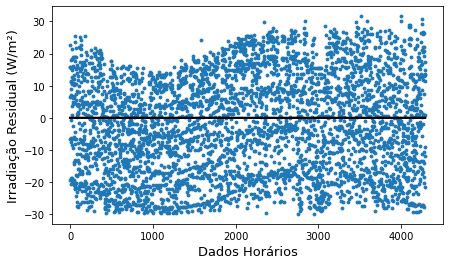

In [286]:
# Resíduos do modelo
rcParams['figure.figsize'] = 7,4
plt.xlabel("Dados Horários",fontsize=13)
plt.ylabel("Irradiação Residual (W/m²)",fontsize=13)
plt.scatter(np.arange(len(np.array(r) - np.array(r2_C))),np.array(r) - np.array(r2_C),s=8)

plt.plot(np.zeros(len(np.array(r) - np.array(r2_C))),color='black',linewidth=2.25)
plt.savefig("residuos-cnn.png", dpi=500, bbox_inches='tight')

## Plot das redes sobrepostos aos valores dados reais em um período de 1 mês

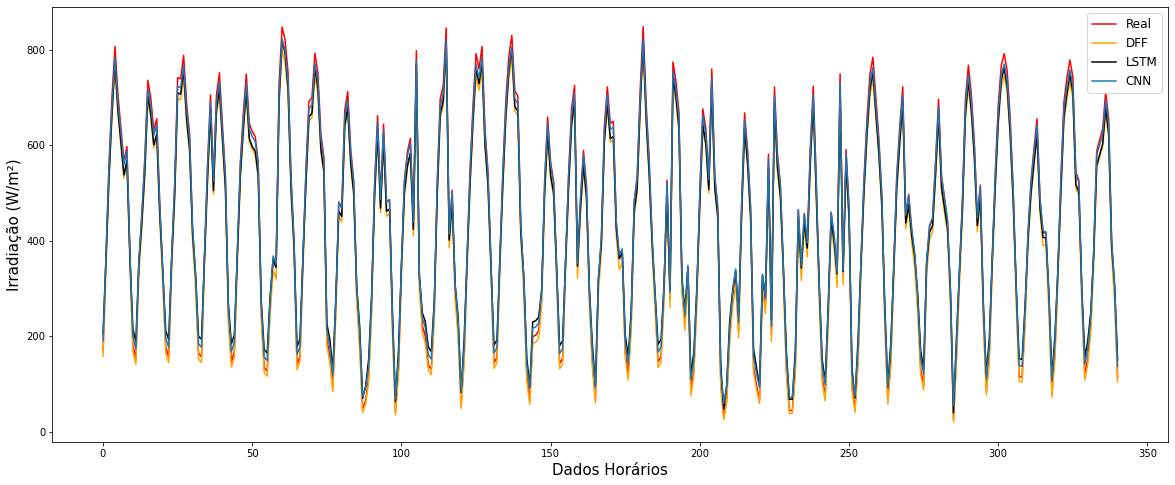

In [275]:
rcParams['figure.figsize'] = 20,8

fig, ax = plt.subplots()

ax4 = ax.plot(r[:11*31].values,label='Real',color='red')
ax1 = ax.plot(r2_D[:11*31],label='DFF',color='orange')
ax2 = ax.plot(r2_L[:11*31],label='LSTM',color='black')
ax3 = ax.plot(r2_C[:11*31],label='CNN')

plt.legend(fontsize='large',loc='upper right',ncol=1)
plt.xlabel('Dados Horários',fontsize=15)
plt.ylabel('Irradiação (W/m²)',fontsize=15)

#.legend(fontsize='medium',bbox_to_anchor = (0.936, 0.815),ncol=1)
plt.savefig("comparacao-modelos.png", dpi=500)
plt.show()


## Testes Estatísticos

#### Teste de Normalidade (Shapiro-Wilk)

In [283]:
stats.shapiro(r.sample(tamanhoAmostra(0.05,len(r))))

ShapiroResult(statistic=0.9705405235290527, pvalue=9.134677725342044e-07)

p-valor < 0.05 indica que ao nível de significância de 95% a hipótese nula é rejeitada, logo os dados não foram extraídos/seguem uma distribuição normal.

#### Teste Não Paramétrico (Friedman)
Comos os dados não seguem uma distribuição normal, será aplicado o teste não paramétrico de Friedman aos dados de validação para verificar se os modelos construídos são iguais (h0).

In [278]:
stat,p = stats.friedmanchisquare(pd.DataFrame(r2_D)[-297:].values.flatten(),
                                 pd.DataFrame(r2_L)[-297:].values.flatten(),
                                 pd.DataFrame(r2_C)[-297:].values.flatten())

In [279]:
print('Statistics=%.3f, p=%.4f' % (stat, p))

Statistics=459.441, p=0.0000


De acordo com o resultado para um nível de significância de 95% o p-valor foi inferior a 0.05. Logo, a h0 é rejeitada, pois os modelos não são iguais.